In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [80]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import ensemble
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

#Imbalanced learn packages
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE #Synthetic Minority Oversampling Technique
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler

In [58]:
provider3 = pd.read_csv('provider3.csv')

In [59]:
patient_record = pd.read_csv('patient_record.csv', low_memory=False)

In [6]:
patient_record.head(2)

,Unnamed: 0,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,patient_type,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,common_patient,Age,noPhysician,chronic_count,ClaimStartMonth,days_admitted,coverage,totalamount_charged,revenue_per_day,annual_amount
0,0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,0,0.0,0.0,0.0,0.0,0.0,NaN,both,1943-01-01,NaN,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,Yes,Both,66,False,7,4,7,0.960544,27068.0,3866.857143,39334
1,1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,0,0,0,0,0,0,0,7092.0,0.0,0.0,0.0,0.0,NaN,both,1943-01-01,NaN,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,No,Both,66,False,7,8,3,0.823995,6068.0,2022.666667,39334


In [13]:
alz_count = patient_record.groupby(['Provider', 'BeneID'])['ChronicCond_Alzheimer'].sum().\
        reset_index(name = 'alz_count')
alz_count = alz_count.groupby('Provider')['alz_count'].sum().reset_index()

In [29]:
renal_count = patient_record.groupby(['Provider', 'BeneID'])['RenalDiseaseIndicator'].sum().\
            reset_index(name = 'renal_count')
renal_count = renal_count.groupby('Provider')['renal_count'].sum().reset_index()

In [43]:
heart_count = patient_record.groupby(['Provider', 'BeneID'])['ChronicCond_Heartfailure'].sum()\
                .reset_index(name = 'heart_count')
heart_count = heart_count.groupby('Provider')['heart_count'].sum().reset_index()

In [45]:
kid_count = patient_record.groupby(['Provider', 'BeneID'])['ChronicCond_KidneyDisease'].sum()\
                .reset_index(name = 'kid_count')
kid_count = kid_count.groupby('Provider')['kid_count'].sum().reset_index()


In [46]:
cancer_count = patient_record.groupby(['Provider', 'BeneID'])['ChronicCond_Cancer'].sum()\
                .reset_index(name = 'cancer_count')
cancer_count = cancer_count.groupby('Provider')['cancer_count'].sum().reset_index()

In [47]:
obstr_count = patient_record.groupby(['Provider', 'BeneID'])['ChronicCond_ObstrPulmonary'].sum()\
                .reset_index(name = 'obstr_count')
obstr_count = obstr_count.groupby('Provider')['obstr_count'].sum().reset_index()

In [48]:
dep_count = patient_record.groupby(['Provider', 'BeneID'])['ChronicCond_Depression'].sum()\
            .reset_index(name = 'dep_count')
dep_count = dep_count.groupby('Provider')['dep_count'].sum().reset_index()

In [49]:
dia_count = patient_record.groupby(['Provider', 'BeneID'])['ChronicCond_Diabetes'].sum()\
            .reset_index(name = 'dia_count')
dia_count = dia_count.groupby('Provider')['dia_count'].sum().reset_index()

In [50]:
icsh_count = patient_record.groupby(['Provider', 'BeneID'])['ChronicCond_IschemicHeart'].sum()\
                .reset_index(name = 'icsh_count')
icsh_count = icsh_count.groupby('Provider')['icsh_count'].sum().reset_index()

In [51]:
ost_count = patient_record.groupby(['Provider', 'BeneID'])['ChronicCond_Osteoporasis'].sum()\
                .reset_index(name = 'ost_count')
ost_count = ost_count.groupby('Provider')['ost_count'].sum().reset_index()

In [52]:
rheu_count = patient_record.groupby(['Provider', 'BeneID'])['ChronicCond_rheumatoidarthritis'].sum()\
            .reset_index(name = 'rheu_count')
rheu_count = rheu_count.groupby('Provider')['rheu_count'].sum().reset_index()

In [53]:
stroke_count = patient_record.groupby(['Provider', 'BeneID'])['ChronicCond_stroke'].sum()\
            .reset_index(name = 'stroke_count')
stroke_count = stroke_count.groupby('Provider')['stroke_count'].sum().reset_index()

In [62]:
provider3 = provider3.merge(alz_count, how = 'left', on = 'Provider')

In [63]:
provider3 = provider3.merge(renal_count, how = 'left', on = 'Provider')

In [64]:
provider3 = provider3.merge(heart_count, how = 'left', on = 'Provider')

In [65]:
provider3 = provider3.merge(kid_count, how = 'left', on = 'Provider')

In [66]:
provider3 = provider3.merge(cancer_count, how = 'left', on = 'Provider')

In [67]:
provider3 = provider3.merge(obstr_count, how = 'left', on = 'Provider')

In [68]:
provider3 = provider3.merge(dep_count, how = 'left', on = 'Provider')

In [69]:
provider3 = provider3.merge(dia_count, how = 'left', on = 'Provider')

In [70]:
provider3 = provider3.merge(icsh_count, how = 'left', on = 'Provider')

In [71]:
provider3 = provider3.merge(ost_count, how = 'left', on = 'Provider')

In [72]:
provider3 = provider3.merge(rheu_count, how = 'left', on = 'Provider')

In [73]:
provider3 = provider3.merge(stroke_count, how = 'left', on = 'Provider')

In [56]:
#Confusion Matrix Plotting Function
def conf_mat(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
    group_percentages = ['{0:.4%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax= plt.subplot()
    sns.heatmap(cm/np.sum(cm), annot=labels, ax = ax, fmt='', cmap='coolwarm');
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['No Fraud', 'Potential Fraud']); ax.yaxis.set_ticklabels(['No Fraud', 'Potential Fraud'])
    return


In [91]:
provider3.head(2)

,Unnamed: 0,Provider,PotentialFraud,patient_count,Race1,Race2,Race3,Race5,Male,Female,mean_age,state_count,phy_count,no_phy,chronic_mean,claim_count,InscClaimAmtReimbursed,DeductibleAmtPaid,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,claimdiag,diag_grp,diag_4019,diag_25000,diag_2724,diag_V5869,diag_4011,diag_42731,diag_V5861,diag_2720,diag_2449,diag_4280,proc_4019,proc_9904,proc_2724,proc_8154,proc_66,proc_3893,proc_3995,proc_4516,proc_3722,proc_8151,patient_duplicate_count,duplicate_claims,totalamount_charged,revenue_day,annual_amount,coverage,inpatient,outpatient,alz_count,renal_count,heart_count,kid_count,cancer_count,obstr_count,dep_count,dia_count,icsh_count,ost_count,rheu_count,stroke_count
0,0,PRV51001,0,24,20.0,4.0,0.0,0.0,9.0,15.0,78.0,1,14,0.0,6.0,25,4185.600000,213.600000,17606.000000,897.120000,2615.200000,463.920000,11.0,5.0,1.0,1.0,2.0,2.0,0.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,4399.200000,593.477613,21582.240000,0.975656,0,0,15,8,19,17,5,10,9,21,23,6,8,6
1,1,PRV51003,1,117,94.0,22.0,0.0,1.0,49.0,68.0,70.0,3,44,0.0,5.0,132,4588.409091,502.166667,7568.181818,931.424242,2678.181818,737.121212,58.0,58.0,12.0,15.0,7.0,16.0,3.0,25.0,11.0,14.0,6.0,7.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,0.0,2.0,0.0,0.0,25.0,5090.575758,767.409611,11914.909091,0.912167,0,0,56,29,80,64,10,41,54,100,112,33,38,12


In [92]:
provider3.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [76]:
x = provider3.drop(['Provider','PotentialFraud'],axis=1)
y = provider3['PotentialFraud']
# train-test split
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(x), y, test_size=0.3, random_state=100)


In [77]:
#Undersampling via Edited Nearest Neighbors
en = EditedNearestNeighbours()
x_en, y_en = en.fit_resample(x, y)

In [78]:
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(StandardScaler().fit_transform(x_en), y_en, 
                                                                test_size=0.3, random_state=100)

Accuracy Score: 0.9372325249643366
F1 Score: 0.6788321167883212
Recall Score: 0.5740740740740741
ROC-AUC Score: 0.7793757467144562


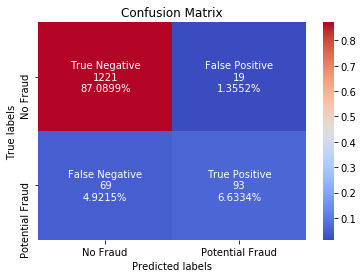

In [82]:
from sklearn.linear_model import LogisticRegressionCV
lg1 = LogisticRegressionCV(cv=10, random_state=100, max_iter=2000)

lg1.fit(X_train_en,y_train_en)

y_pred_en = lg1.predict(X_test_en)
# performance
print(f'Accuracy Score: {accuracy_score(y_test_en,y_pred_en)}')
print('F1 Score: {}'.format(f1_score(y_test_en, y_pred_en)))
print('Recall Score: {}'.format(recall_score(y_test_en, y_pred_en)))
print('ROC-AUC Score: {}'.format(roc_auc_score(y_test_en, y_pred_en)))
conf_mat(y_test_en, y_pred_en)

In [84]:
# Feature Importance for logistic regression(undersampling) top 15 features
pd.DataFrame(zip(x.columns, np.transpose(lg1.coef_.tolist()[0])), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

,feature,coef
21,diag_grp,0.685595
28,diag_V5861,0.419327
20,claimdiag,0.361061
40,proc_3722,0.327108
32,proc_4019,0.301163
39,proc_4516,0.289296
15,DeductibleAmtPaid,0.257826
36,proc_66,0.234180
38,proc_3995,0.207657
42,patient_duplicate_count,0.191392


Random Forest Accuracy Score: 0.9372325249643366
Random Forest F1 Score: 0.6879432624113475
Recall Score for Random Forest: 0.5987654320987654
ROC-AUC Score for Random Forest: 0.7901085225009956


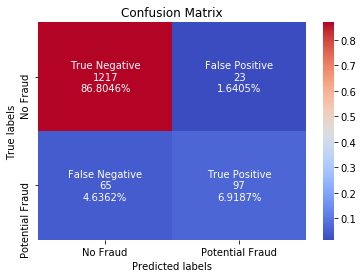

In [85]:
rF2 = ensemble.RandomForestClassifier()
rF2.fit(X_train_en, y_train_en)
y_pred_en = rF2.predict(X_test_en)
print(f'Random Forest Accuracy Score: {accuracy_score(y_test_en,y_pred_en)}')
print('Random Forest F1 Score: {}'.format(f1_score(y_test_en, y_pred_en)))
print('Recall Score for Random Forest: {}'.format(recall_score(y_test_en, y_pred_en)))
print('ROC-AUC Score for Random Forest: {}'.format(roc_auc_score(y_test_en, y_pred_en)))
conf_mat(y_test_en, y_pred_en)

In [86]:
#Feature selection by Random forest

pd.DataFrame(zip(x.columns, list(rF2.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

,feature,coef
21,diag_grp,0.135248
20,claimdiag,0.047635
28,diag_V5861,0.040441
29,diag_2720,0.039939
37,proc_3893,0.038920
14,InscClaimAmtReimbursed,0.035976
33,proc_9904,0.028774
45,revenue_day,0.028028
44,totalamount_charged,0.025659
27,diag_42731,0.022714


Gradient Boost Accuracy Score: 0.9358059914407989
Gradient Boost F1 Score: 0.6938775510204083
Recall Score for Gradient Boost: 0.6296296296296297
ROC-AUC Score for Gradient Boost: 0.8027180406212665


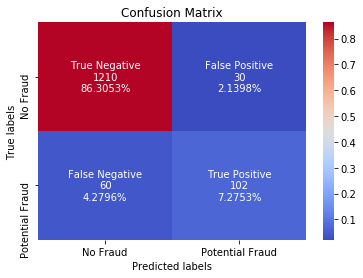

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(X_train_en, y_train_en)
y_pred_en = clf.predict(X_test_en)
print(f'Gradient Boost Accuracy Score: {accuracy_score(y_test_en,y_pred_en)}')
print('Gradient Boost F1 Score: {}'.format(f1_score(y_test_en, y_pred_en)))
print('Recall Score for Gradient Boost: {}'.format(recall_score(y_test_en, y_pred_en)))
print('ROC-AUC Score for Gradient Boost: {}'.format(roc_auc_score(y_test_en, y_pred_en)))
conf_mat(y_test_en, y_pred_en)

In [88]:
pd.DataFrame(zip(x.columns, list(clf.feature_importances_)), columns=['feature', 'coef'])\
            .sort_values('coef', ascending=False).head(15)

,feature,coef
21,diag_grp,0.635092
28,diag_V5861,0.061283
20,claimdiag,0.036330
44,totalamount_charged,0.023089
46,annual_amount,0.019973
16,IPAnnualReimbursementAmt,0.018022
45,revenue_day,0.016382
56,dep_count,0.015640
14,InscClaimAmtReimbursed,0.011751
51,renal_count,0.010070


In [102]:
from sklearn.metrics import recall_score, precision_score, mean_squared_log_error, mean_squared_error,confusion_matrix,\
        roc_auc_score, f1_score, plot_roc_curve, roc_curve, RocCurveDisplay, auc, precision_recall_curve,\
        fbeta_score, make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier,GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


In [103]:
def evaluate_model(X_train, X_test, y_train, y_test):
    classifiers = [LogisticRegression(penalty='l1', solver='liblinear'),LogisticRegressionCV(cv = 5, penalty='l1',solver='liblinear'),
                   LinearSVC(),GaussianNB(),LinearDiscriminantAnalysis(),RandomForestClassifier(),
                   GradientBoostingClassifier(),XGBClassifier()]
    
    for classifier in classifiers:
    
        model = Pipeline(steps = [('classifier', classifier)])
    
        model.fit(X_train, y_train)
        
        predicted_train = model.predict(X_train)
        predicted_test = model.predict(X_test)
    
    
        print(type(classifier).__name__)
        print('Accuracy Score for train data: {:.3f}'.format(accuracy_score(y_train, predicted_train)))
        print('Accuracy Score for test data: {:.3f}'.format(accuracy_score(y_test, predicted_test)))
        print('Recall Score for train data {:.3f}'.format(recall_score(y_train, predicted_train)))
        print('Recall Score for test data {:.3f}'.format(recall_score(y_test, predicted_test)))
        print('fbeta0.2_score for train data{:.3f}'.format(fbeta_score(y_train, predicted_train, beta = 2)))
        print('fbeta0.2_score for test data{:.3f}'.format(fbeta_score(y_test, predicted_test, beta = 2)))
        print('ROC-AUC Score for train data: {:.3f}'.format(roc_auc_score(y_train, predicted_train)))
        print('ROC-AUC Score for test data: {:.3f}'.format(roc_auc_score(y_test, predicted_test)))
        print('Confusion matrix for train data')
        print(confusion_matrix(y_train, predicted_train))
        print('Confusion matrix for test data')
        print(confusion_matrix(y_test, predicted_test))
        print('-' *50)


In [104]:
print(evaluate_model(X_train_en, X_test_en, y_train_en, y_test_en))

LogisticRegression
Accuracy Score for train data: 0.953
Accuracy Score for test data: 0.937
Recall Score for train data 0.666
Recall Score for test data 0.586
fbeta0.2_score for train data0.696
fbeta0.2_score for test data0.622
ROC-AUC Score for train data: 0.826
ROC-AUC Score for test data: 0.785
Confusion matrix for train data
[[2887   39]
 [ 115  229]]
Confusion matrix for test data
[[1219   21]
 [  67   95]]
--------------------------------------------------
LogisticRegressionCV
Accuracy Score for train data: 0.952
Accuracy Score for test data: 0.937
Recall Score for train data 0.657
Recall Score for test data 0.586
fbeta0.2_score for train data0.689
fbeta0.2_score for test data0.622
ROC-AUC Score for train data: 0.822
ROC-AUC Score for test data: 0.785
Confusion matrix for train data
[[2888   38]
 [ 118  226]]
Confusion matrix for test data
[[1219   21]
 [  67   95]]
--------------------------------------------------


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC
Accuracy Score for train data: 0.953
Accuracy Score for test data: 0.936
Recall Score for train data 0.651
Recall Score for test data 0.568
fbeta0.2_score for train data0.685
fbeta0.2_score for test data0.605
ROC-AUC Score for train data: 0.820
ROC-AUC Score for test data: 0.776
Confusion matrix for train data
[[2892   34]
 [ 120  224]]
Confusion matrix for test data
[[1220   20]
 [  70   92]]
--------------------------------------------------
GaussianNB
Accuracy Score for train data: 0.920
Accuracy Score for test data: 0.911
Recall Score for train data 0.709
Recall Score for test data 0.642
fbeta0.2_score for train data0.685
fbeta0.2_score for test data0.635
ROC-AUC Score for train data: 0.827
ROC-AUC Score for test data: 0.794
Confusion matrix for train data
[[2765  161]
 [ 100  244]]
Confusion matrix for test data
[[1173   67]
 [  58  104]]
--------------------------------------------------
LinearDiscriminantAnalysis
Accuracy Score for train data: 0.949
Accuracy Score for 

/Applications/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier
Accuracy Score for train data: 1.000
Accuracy Score for test data: 0.939
Recall Score for train data 1.000
Recall Score for test data 0.648
fbeta0.2_score for train data1.000
fbeta0.2_score for test data0.671
ROC-AUC Score for train data: 1.000
ROC-AUC Score for test data: 0.812
Confusion matrix for train data
[[2926    0]
 [   0  344]]
Confusion matrix for test data
[[1211   29]
 [  57  105]]
--------------------------------------------------
None
